In [3]:
import os, math
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt


from pyArango.connection import *
from pyArango.collection import *
from pyArango.graph import *



In [4]:
def return_results_from_DB_gridOnly(aql):
    conn = Connection()
    db = conn["_system"]
    results = db.AQLQuery(aql, rawResults=True, batchSize=100000, count=False)
    
    tempList=[]
    
    for s in results:
        tempText = str(s)
    
    tempText2 = tempText.replace("{'grid': ","").replace("}","")
    
 
    first = True
    
    for f in tempText2.replace("[[","").replace("]]","").split("], ["):
        if first:
            nD_array=np.asarray(f.split(","))
            first = False
        else:
            nD_array = np.vstack((nD_array,
                                  np.asarray(f.split(","))))
        
    rLLGI_mean = np.mean(nD_array.astype(np.float), axis=0)
  
# this is for bulkGrid (the sigmaA curve)
#     FSOL = np.asarray([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9])
#     BSOL = np.asarray([50,100,150,200,250,300,350,400,450,500,50,100,150,200,250,300,350,400,450,500,50,100,150,200,250,300,350,400,450,500,50,100,150,200,250,300,350,400,450,500,50,100,150,200,250,300,350,400,450,500])

# this is for bulkSolvent (the bulkSolvent curve)
#     FSOL = np.asarray([0.1,0.1,0.1,0.1,0.1,0.2,0.2,0.2,0.2,0.2,0.3,0.3,0.3,0.3,0.3,0.4,0.4,0.4,0.4,0.4,0.5,0.5,0.5,0.5,0.5])
#     BSOL = np.asarray([25,50,75,100,125,25,50,75,100,125,25,50,75,100,125,25,50,75,100,125,25,50,75,100,125])

# this is for sigmaA2grid (the SigmaA curve)
    FSOL = np.asarray([0.1,0.1,0.1,0.1,0.2,0.2,0.2,0.2,0.3,0.3,0.3,0.3,0.4,0.4,0.4,0.4])
    BSOL = np.asarray([10,30,50,70,10,30,50,70,10,30,50,70,10,30,50,70])
    

    rDF_numpy = np.array([(BSOL), (FSOL), rLLGI_mean]).transpose()
    rDF = pd.DataFrame({'BSOL': rDF_numpy[:, 0], 'FSOL': rDF_numpy[:, 1], 'rLLGI': rDF_numpy[:, 2]})
#     print("unsorted \n ", rDF)
    rDF_reindex = rDF.sort_values(by=['FSOL', 'BSOL']).reset_index(drop=True)
#     print("sorted \n", rDF_reindex)

    return rDF


def contour_plotting_for_a_specificPair(subset_pd, title, variableColumnName):
    subset_pd
    matrix_constructed = subset_pd.pivot('BSOL', 'FSOL', variableColumnName)

    ###plotting
    X=matrix_constructed.columns.values
    Y=matrix_constructed.index.values
    Z=matrix_constructed.values

    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(X, Y, Z)
#     print("This is cp values \n ", cp)
#     fig.colorbar(cp) # Add a colorbar to a plot
    fig.colorbar(cp, label=variableColumnName)
#     fig.colorbar(ticks=range(1000), label='digit value')
    type(cp)
    dir(cp)
    ax.set_title(title)
    ax.set_xlabel('FSOL')
    ax.set_ylabel('BSOL')

    #x,y=np.meshgrid(X, Y)
#     return X, Y, Z
    plt.contourf(X, Y, Z)

# contour_plotting_usingOnlyArrayOfGrid(return_results_from_DB(aql3), "90% > scattering")

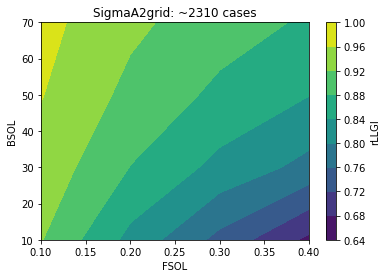

In [5]:
# query = str("FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel            FILTER s.SequenceIdentity<100 AND s.LLGI<1000 AND s.FractionalScattering<0.5    AND s.gonnet_Nscore>0          AND s.bulkGrid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.bulkGrid[*].rLLGI                   RETURN k-s.LLGI),        gridFSOL = s.bulkGrid[*].FSOL,        gridBSOL = s.bulkGrid[*].BSOL    COLLECT FSOL_c= gridFSOL,             BSOL_c = gridBSOL            INTO valuesByGridPoint KEEP grid    RETURN {            grid:(valuesByGridPoint[*].grid)            }")
FILTER = "FILTER s.gonnet_Nscore>0 AND s.FractionalScattering>0 AND tPDBID.WilsonB >0"
# query = "FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel    "+ FILTER+ "           AND s.bulkGrid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.bulkGrid[*].rLLGI                   RETURN k/s.LLGI),        gridFSOL = s.bulkGrid[*].FSOL,        gridBSOL = s.bulkGrid[*].BSOL    COLLECT FSOL_c= gridFSOL,             BSOL_c = gridBSOL            INTO valuesByGridPoint KEEP grid    RETURN {            grid:(valuesByGridPoint[*].grid)            }"
query = "FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel    "+ FILTER+ "           AND s.sigmaA2grid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.sigmaA2grid[*].rVRMS RETURN k/s.VRMS), gridFSOL = s.sigmaA2grid[*].FSOL, gridBSOL = s.sigmaA2grid[*].BSOL COLLECT FSOL_c= gridFSOL, BSOL_c = gridBSOL INTO valuesByGridPoint KEEP grid RETURN { grid:(valuesByGridPoint[*].grid) }"
contour_plotting_for_a_specificPair(return_results_from_DB_gridOnly(query), "SigmaA2grid: ~2310 cases", "rLLGI")


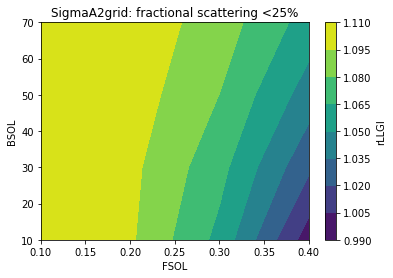

In [347]:
# query = str("FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel            FILTER s.SequenceIdentity<100 AND s.LLGI<1000 AND s.FractionalScattering<0.5    AND s.gonnet_Nscore>0          AND s.bulkGrid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.bulkGrid[*].rLLGI                   RETURN k-s.LLGI),        gridFSOL = s.bulkGrid[*].FSOL,        gridBSOL = s.bulkGrid[*].BSOL    COLLECT FSOL_c= gridFSOL,             BSOL_c = gridBSOL            INTO valuesByGridPoint KEEP grid    RETURN {            grid:(valuesByGridPoint[*].grid)            }")
FILTER = "FILTER s.gonnet_Nscore>0 AND s.FractionalScattering>0 AND s.FractionalScattering<0.25 AND tPDBID.WilsonB >0"
# query = "FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel    "+ FILTER+ " AND s.bulkGrid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.bulkGrid[*].rLLGI                   RETURN k/s.LLGI),        gridFSOL = s.bulkGrid[*].FSOL,        gridBSOL = s.bulkGrid[*].BSOL    COLLECT FSOL_c= gridFSOL,             BSOL_c = gridBSOL            INTO valuesByGridPoint KEEP grid    RETURN {            grid:(valuesByGridPoint[*].grid)            }"
query = "FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel    "+ FILTER+ "           AND s.sigmaA2grid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.sigmaA2grid[*].rLLGI RETURN k/s.LLGI), gridFSOL = s.sigmaA2grid[*].FSOL, gridBSOL = s.sigmaA2grid[*].BSOL COLLECT FSOL_c= gridFSOL, BSOL_c = gridBSOL INTO valuesByGridPoint KEEP grid RETURN { grid:(valuesByGridPoint[*].grid) }"
contour_plotting_for_a_specificPair(return_results_from_DB_gridOnly(query), "SigmaA2grid: fractional scattering <25%", "rLLGI")


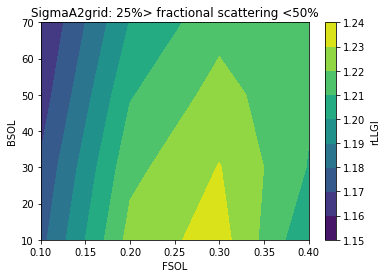

In [348]:
# query = str("FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel            FILTER s.SequenceIdentity<100 AND s.LLGI<1000 AND s.FractionalScattering<0.5    AND s.gonnet_Nscore>0          AND s.bulkGrid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.bulkGrid[*].rLLGI                   RETURN k-s.LLGI),        gridFSOL = s.bulkGrid[*].FSOL,        gridBSOL = s.bulkGrid[*].BSOL    COLLECT FSOL_c= gridFSOL,             BSOL_c = gridBSOL            INTO valuesByGridPoint KEEP grid    RETURN {            grid:(valuesByGridPoint[*].grid)            }")
FILTER = "FILTER s.gonnet_Nscore>0 AND s.FractionalScattering>=0.25 AND s.FractionalScattering<0.50 AND tPDBID.WilsonB >0"
# query = "FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel    "+ FILTER+ "           AND s.bulkGrid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.bulkGrid[*].rLLGI                   RETURN k/s.LLGI),        gridFSOL = s.bulkGrid[*].FSOL,        gridBSOL = s.bulkGrid[*].BSOL    COLLECT FSOL_c= gridFSOL,             BSOL_c = gridBSOL            INTO valuesByGridPoint KEEP grid    RETURN {            grid:(valuesByGridPoint[*].grid)            }"
query = "FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel    "+ FILTER+ "           AND s.sigmaA2grid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.sigmaA2grid[*].rLLGI RETURN k/s.LLGI), gridFSOL = s.sigmaA2grid[*].FSOL, gridBSOL = s.sigmaA2grid[*].BSOL COLLECT FSOL_c= gridFSOL, BSOL_c = gridBSOL INTO valuesByGridPoint KEEP grid RETURN { grid:(valuesByGridPoint[*].grid) }"
contour_plotting_for_a_specificPair(return_results_from_DB_gridOnly(query), "SigmaA2grid: 25%> fractional scattering <50%", "rLLGI")


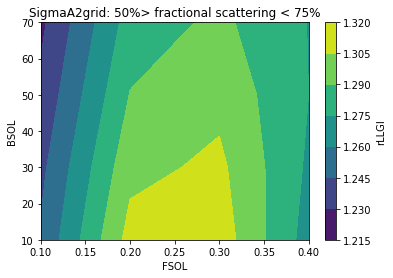

In [349]:
# query = str("FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel            FILTER s.SequenceIdentity<100 AND s.LLGI<1000 AND s.FractionalScattering<0.5    AND s.gonnet_Nscore>0          AND s.bulkGrid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.bulkGrid[*].rLLGI                   RETURN k-s.LLGI),        gridFSOL = s.bulkGrid[*].FSOL,        gridBSOL = s.bulkGrid[*].BSOL    COLLECT FSOL_c= gridFSOL,             BSOL_c = gridBSOL            INTO valuesByGridPoint KEEP grid    RETURN {            grid:(valuesByGridPoint[*].grid)            }")
FILTER = "FILTER s.gonnet_Nscore>0  AND s.FractionalScattering>=0.5 AND s.FractionalScattering<0.75 AND tPDBID.WilsonB >0"
# query = "FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel    "+ FILTER+ "           AND s.bulkGrid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.bulkGrid[*].rLLGI                   RETURN k/s.LLGI),        gridFSOL = s.bulkGrid[*].FSOL,        gridBSOL = s.bulkGrid[*].BSOL    COLLECT FSOL_c= gridFSOL,             BSOL_c = gridBSOL            INTO valuesByGridPoint KEEP grid    RETURN {            grid:(valuesByGridPoint[*].grid)            }"
query = "FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel    "+ FILTER+ "           AND s.sigmaA2grid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.sigmaA2grid[*].rLLGI RETURN k/s.LLGI), gridFSOL = s.sigmaA2grid[*].FSOL, gridBSOL = s.sigmaA2grid[*].BSOL COLLECT FSOL_c= gridFSOL, BSOL_c = gridBSOL INTO valuesByGridPoint KEEP grid RETURN { grid:(valuesByGridPoint[*].grid) }"
contour_plotting_for_a_specificPair(return_results_from_DB_gridOnly(query), "SigmaA2grid: 50%> fractional scattering < 75%", "rLLGI")


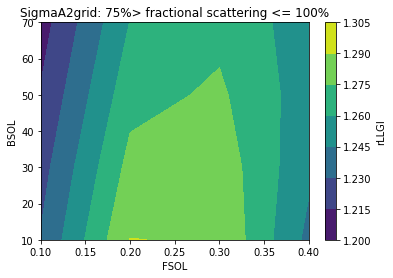

In [350]:
# query = str("FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel            FILTER s.SequenceIdentity<100 AND s.LLGI<1000 AND s.FractionalScattering<0.5    AND s.gonnet_Nscore>0          AND s.bulkGrid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.bulkGrid[*].rLLGI                   RETURN k-s.LLGI),        gridFSOL = s.bulkGrid[*].FSOL,        gridBSOL = s.bulkGrid[*].BSOL    COLLECT FSOL_c= gridFSOL,             BSOL_c = gridBSOL            INTO valuesByGridPoint KEEP grid    RETURN {            grid:(valuesByGridPoint[*].grid)            }")
FILTER = "FILTER s.gonnet_Nscore>0  AND s.FractionalScattering>=0.5 AND tPDBID.WilsonB >0"
# query = "FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel    "+ FILTER+ "           AND s.bulkGrid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.bulkGrid[*].rLLGI                   RETURN k/s.LLGI),        gridFSOL = s.bulkGrid[*].FSOL,        gridBSOL = s.bulkGrid[*].BSOL    COLLECT FSOL_c= gridFSOL,             BSOL_c = gridBSOL            INTO valuesByGridPoint KEEP grid    RETURN {            grid:(valuesByGridPoint[*].grid)            }"
query = "FOR tPDBID IN target  FOR p, s IN INBOUND tPDBID processedModel    "+ FILTER+ "           AND s.sigmaA2grid !=  null    LET oriLLGI = s.LLGI,         grid = (for k in s.sigmaA2grid[*].rLLGI RETURN k/s.LLGI), gridFSOL = s.sigmaA2grid[*].FSOL, gridBSOL = s.sigmaA2grid[*].BSOL COLLECT FSOL_c= gridFSOL, BSOL_c = gridBSOL INTO valuesByGridPoint KEEP grid RETURN { grid:(valuesByGridPoint[*].grid) }"
contour_plotting_for_a_specificPair(return_results_from_DB_gridOnly(query), "SigmaA2grid: 75%> fractional scattering <= 100%", "rLLGI")
